# Feed-forward Neural Network

In diesem Notebook schauen wir uns Neuronale Netze an.
In der Praxis verwendet man für Bilddaten üblicherweise Convolutional Neural Networks (CNNs); diese haben wir im Theorie Teil aber nicht im Detail angeschaut.
Daher verwenden wir hier Feed-forward Neural Networks mit einem Hidden Layer.

Das Neuronale Netz ist in `tensorflow` programmiert.

In [1]:
!pip install tensorflow==2.6

You should consider upgrading via the '/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, activations, Sequential, losses
from tensorflow.keras.regularizers import L2

import pickle

import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [4]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
      display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

# Daten vorbereiten

In [5]:
# Daten laden und aufteilen in Features und Labels
with open('../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

##### Preprocessing

Für tensorflow müssen wir die Text-Labels (wie `frog`) in Zahlen umwandeln. Dazu verwenden wir den `LabelEncoder`.

Die Daten werden hier mittels `tf.image.per_image_standardization` standardisiert.

In [7]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [8]:
# tf.image.per_image_standardization ist ein übliches Preprocessing für Bilddaten.
X_train_std = tf.image.per_image_standardization(X_train).numpy()
X_val_std = tf.image.per_image_standardization(X_val).numpy()

2021-11-05 14:00:24.949372: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### NN (0 hidden layer -> Logistic Regression)

Zuerst bauen wir die `Logistic Regression` als Neural Network nach.

![Logistic Regression als Neural Network](./img/logistic_regression_as_nn.png)

Die Performanz sollte ähnlich sein zu unserer `Logistic Regression` Baseline.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output_layer (Dense)         (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40


2021-11-05 14:00:26.948442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


293/293 [==============================] - 1s 2ms/step - loss: 2.1538 - accuracy: 0.3227 - val_loss: 2.0284 - val_accuracy: 0.3491
Epoch 2/40
293/293 [==============================] - 1s 2ms/step - loss: 1.9733 - accuracy: 0.3727 - val_loss: 1.9763 - val_accuracy: 0.3610

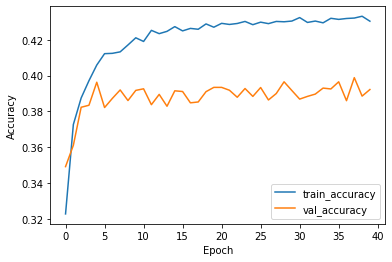

0.39224


In [9]:
lr = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(10, activation=activations.linear, kernel_regularizer=L2(), name='output_layer'),
])
lr.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(lr.summary())

history = lr.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = lr.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

#### NN (1 hidden layer) no Regularization

Nun fügen wir einen `Hidden Layer` hinzu.

![Neural Network mit einem Hidden Layer](./img/one_hidden_nn.png)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 1024)              3146752   
_________________________________________________________________
output_layer (Dense)         (None, 10)                10250     
Total params: 3,157,002
Trainable params: 3,157,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
293/293 [==============================] - 4s 14ms/step - loss: 1.7805 - accuracy: 0.3769 - val_loss: 1.6330 - val_accuracy: 0.4242

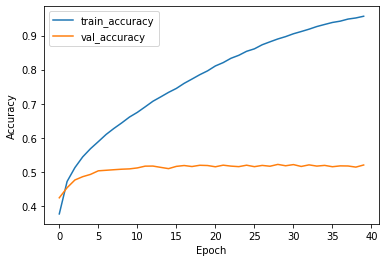

0.52032


In [10]:
nn = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(1024, activation=activations.relu, name='hidden_layer'),
    layers.Dense(10, activation=activations.linear, name='output_layer'),
])
nn.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(nn.summary())

history = nn.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = nn.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

#### NN (1 hidden layer) with L2 Regularization

Nun fügen wir L2 Regularisierung hinzu, um gegen das Overfitting zu helfen.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 1024)              3146752   
_________________________________________________________________
output_layer (Dense)         (None, 10)                10250     
Total params: 3,157,002
Trainable params: 3,157,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
293/293 [==============================] - 8s 25ms/step - loss: 16.4659 - accuracy: 0.3686 - val_loss: 15.4612 - val_accuracy: 0.4251

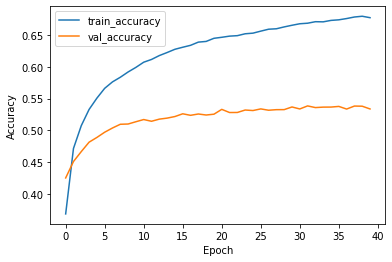

0.5336


In [11]:
nn_l2 = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(1024, activation=activations.relu, kernel_regularizer=L2(0.01), name='hidden_layer'),
    layers.Dense(10, activation=activations.linear, kernel_regularizer=L2(0.01), name='output_layer'),
])
nn_l2.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(nn_l2.summary())

history = nn_l2.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = nn_l2.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

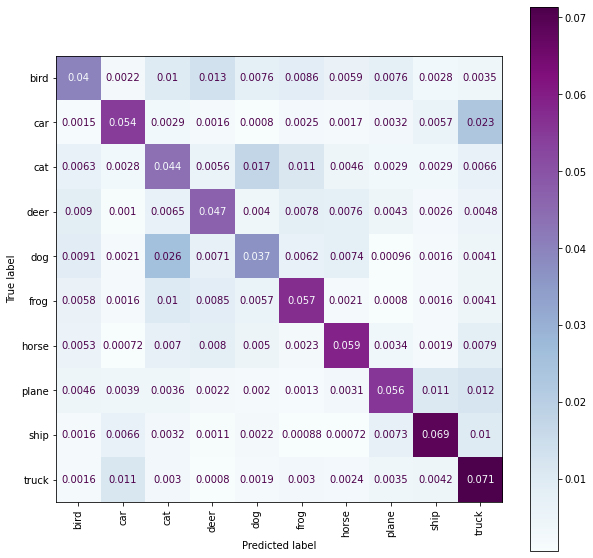

In [12]:
plot_confusion_matrix(
    y_true=y_val,
    y_pred=le.inverse_transform(y_val_hat)
)

# Anwendung des Modells auf dem Test Set

Wenn wir mit der Leistung unseres Modells auf dem `Validation Set` zufrieden sind, können wir es auf das `Test Set` anwenden.

In [13]:
# Daten laden und aufteilen in Features und Labels
with open('../data/test.pkl', 'rb') as f:
    data_test = pickle.load(f)
X_test = data_test["images"]
y_test = data_test["labels"]

In [16]:
X_test_std = tf.image.per_image_standardization(X_test).numpy()
# Das Neurale Netz gibt Wahrscheinlichkeiten zurück
y_test_pred_prob = nn_l2.predict(X_test.reshape(-1, 32 * 32 * 3))
# Hier nehmen wir den Klassen-Index mit der höchsten Wahrscheinlichkeit
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
# Und verwandeln diesen Klassen-Index (z.B. 1) in das entsprechende Klassen-Label (z.B. 'car')
y_test_pred_enc = le.inverse_transform(y_test_pred)

Evaluieren wir unsere test-set predictions

In [17]:
accuracy_score(y_true=y_test, y_pred=y_test_pred_enc)